# Lecture outline

1. Experimental framework implementation
1. Performance evaluation
1. Assignments

# 1. Experimental framework implementation

## Best practice to implement $n$ heuristics and $m$ objective functions?

* There are some common characteristics for all objects in our framework
  * Heuristics - store best found solution, manage stop criterion, etc.
  * Objective functions - store $f^*$, lower/upper bounds, etc.
* Every specific heuristic or obj. function implements its own search space exploration or evaluation, neighbourhood generation, etc.
* Thus, object-oriented design should help us to separate this concerns as much as possible and also to keep us sane


<img src="img/oop_design.png">


## Example: generalized Shoot&Go and two objective functions (AirShip and `sum(x)`)


### Generalized Shoot&Go: $\mathrm{SG}_{hmax}$

* Shoot & Go heuristic (also known as *Iterated Local Search*, *Random-restart hill climbing*, etc)
    * $hmax \in \{ 0, 1, \ldots, \infty \}$ parameter - maximum number of local searches / hill climbs
    * note that $\mathrm{SG}_{0}$ is pure Random Shooting (Random Search)
    
* implemented as ``class ShootAndGo(Heuristic)`` in ``src/heur.py``    
    
### Objective functions

#### AirShip

* Same as on previous lecture, but wee need to **minimize** obj. function values
* implemented as ``class AirShip(ObjFun)`` in ``src/objfun.py``

#### `sum(x)`

* Just as demonstration of vectorized lower/upper bounds
* implemented as ``class Sum(ObjFun)`` in ``src/objfun.py``

**Review the code, please!**

# 2. Performance evaluation

## What is the recommended approach to store and analyze results of your experiments?

1. Append all relevant statistics from a single run into table (e.g. CSV file in memory or on disk), including all task and heuristic parameters 
2. Load the table into analytical tool of your choice (data frames, Excel or Google Docs spreadsheets, etc.)
3. Pivot by relevant parameters, visualize in tables or charts

## Demonstration

Neccessary notebook setup first:

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd,'../src'))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

In [2]:
# Import extrenal librarires
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# Import our code
from heur import ShootAndGo

### General experiment setup

Runs selected objective function (`of`) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [3]:
def experiment(of, num_runs, hmax):
    results = []
    for i in tqdm_notebook(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=100, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])

### Air Ship experiments

In [4]:
from objfun import AirShip
of = AirShip()

In [5]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of, 10000, hmax)
    table = pd.concat([table, res], axis=0)

In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 9999
Data columns (total 6 columns):
heur      80000 non-null object
run       80000 non-null int64
hmax      80000 non-null float64
best_x    80000 non-null int64
best_y    80000 non-null float64
neval     80000 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.3+ MB


In [7]:
table.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,47,-94.0,inf
1,SG_0,1,0.0,49,-98.0,inf
2,SG_0,2,0.0,52,-96.0,inf
3,SG_0,3,0.0,32,-64.0,inf
4,SG_0,4,0.0,49,-98.0,inf


In [8]:
# import visualization libraries
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Quality of solutions based on `hmax`?

In **tabular** form:

In [9]:
table.groupby(['hmax'])['best_y'].median()

hmax
0.000000    -94.000000
1.000000    -86.000000
2.000000    -86.000000
5.000000    -72.000000
10.000000   -60.000000
20.000000   -48.989899
50.000000   -27.777778
inf         -24.500000
Name: best_y, dtype: float64

In [10]:
table.groupby(['hmax'])['best_y'].mean()

hmax
0.000000    -92.171925
1.000000    -80.248057
2.000000    -80.338699
5.000000    -68.549524
10.000000   -62.662945
20.000000   -55.051758
50.000000   -45.259740
inf         -38.033216
Name: best_y, dtype: float64

Feel free to compute other statistics instead of median and mean.

Directly as **Box-Whiskers plot**:

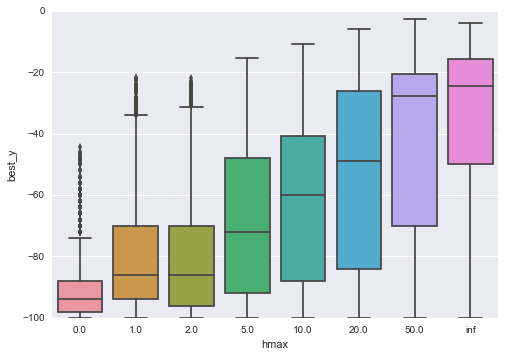

In [11]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on `hmax`?

Let's add another columns, `success`:

In [12]:
table['success'] = table['neval'] < np.inf

In [13]:
table[table['success'] == True].head()

,heur,run,hmax,best_x,best_y,neval,success
18,SG_0,18,0.0,50,-100.0,8.0,True
21,SG_0,21,0.0,50,-100.0,39.0,True
31,SG_0,31,0.0,50,-100.0,15.0,True
34,SG_0,34,0.0,50,-100.0,58.0,True
38,SG_0,38,0.0,50,-100.0,81.0,True


In [14]:
table[table['success'] == False].head()

,heur,run,hmax,best_x,best_y,neval,success
0,SG_0,0,0.0,47,-94.0,inf,False
1,SG_0,1,0.0,49,-98.0,inf,False
2,SG_0,2,0.0,52,-96.0,inf,False
3,SG_0,3,0.0,32,-64.0,inf,False
4,SG_0,4,0.0,49,-98.0,inf,False


Table:

In [15]:
table[table['success'] == True].groupby(['hmax'])['neval'].mean()

hmax
0.000000     48.930419
1.000000     50.074775
2.000000     49.414150
5.000000     50.255814
10.000000    50.132676
20.000000    48.738714
50.000000    49.758323
inf          53.357182
Name: neval, dtype: float64

In [16]:
table[table['success'] == True].groupby(['hmax'])['neval'].median()

hmax
0.000000     48.0
1.000000     49.0
2.000000     48.0
5.000000     49.0
10.000000    50.0
20.000000    47.0
50.000000    48.0
inf          54.0
Name: neval, dtype: float64

Chart:

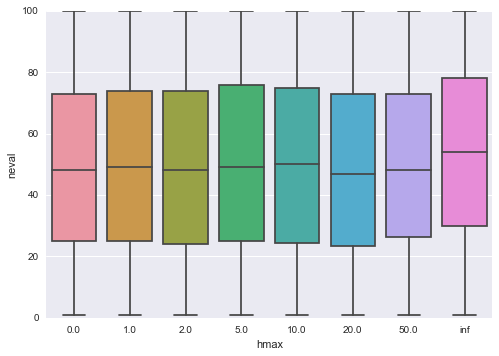

In [17]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability

In [18]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [19]:
rel_by_hmax

,neval
hmax,
0.000000,0.1121
1.000000,0.1110
2.000000,0.1159
5.000000,0.1247
10.000000,0.1319
20.000000,0.1462
50.000000,0.1622
inf,0.1831


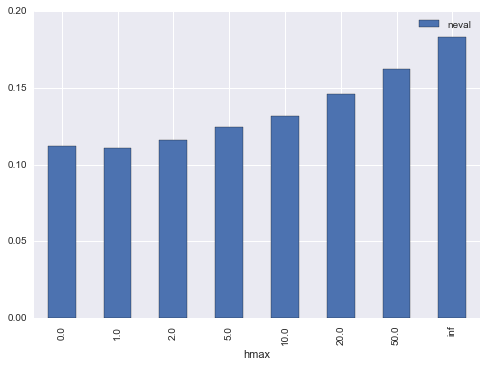

In [20]:
ax = rel_by_hmax.plot(kind='bar')

#### Speed, normalized by reliability?

* Reliability: $REL = m/q$ where $m$ is number of successful runs and $q$ is total number of runs, $REL \in [0, 1]$
* Mean Number of objective function Evaluations: $MNE = \frac{1}{m} \sum_{i=1}^m neval_i$
* Feoktistov criterion: $FEO = MNE/REL$

In [21]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
    #                 ^^^   mean number of evaluations ^^^ / ^^^             reliability         ^^^^
)

In [22]:
feo_by_hmax

,neval
hmax,
0.000000,436.489021
1.000000,451.124097
2.000000,426.351597
5.000000,403.013745
10.000000,380.080942
20.000000,333.370137
50.000000,306.771412
inf,291.410059


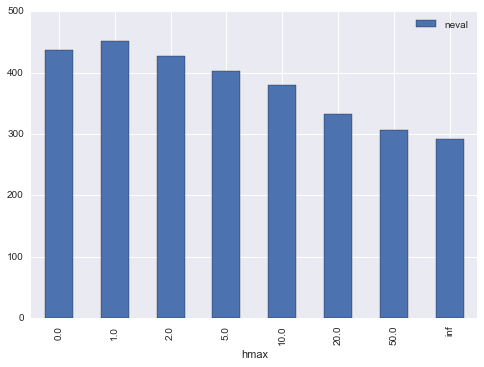

In [28]:
ax = feo_by_hmax.plot(kind='bar')

### `sum(x)` experiments

Let's review this function a little bit:

In [29]:
from objfun import Sum
of = Sum([0, 0, 0, 0], [10, 10, 10, 10])

In [30]:
x = of.generate_point()
print(x)
print(of.evaluate(x))

[4, 8, 3, 8]
23


In [31]:
print(of.get_neighborhood(x, 1))

[[3, 8, 3, 8], [5, 8, 3, 8], [4, 7, 3, 8], [4, 9, 3, 8], [4, 8, 2, 8], [4, 8, 4, 8], [4, 8, 3, 7], [4, 8, 3, 9]]


In [32]:
print(of.get_neighborhood(x, 2))

AssertionError: Sum(x) supports neighbourhood with distance = 1 only

In [33]:
of.get_neighborhood([0, 0, 0, 0], 1)

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

In [34]:
of.get_neighborhood([10, 10, 10, 10], 1)

[[9, 10, 10, 10], [10, 9, 10, 10], [10, 10, 9, 10], [10, 10, 10, 9]]

And now, perform traditional experiments:

In [35]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of, 10000, hmax)
    table = pd.concat([table, res], axis=0)

#### Quality of solutions based on hmax?

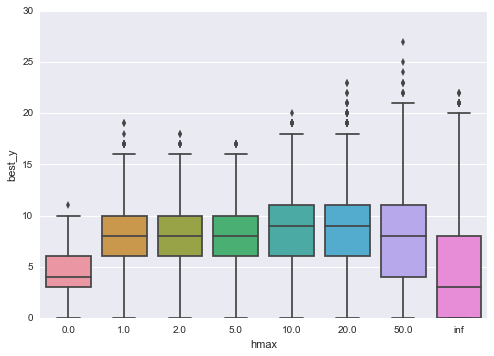

In [36]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on hmax?

In [37]:
table['success'] = table['neval'] < np.inf

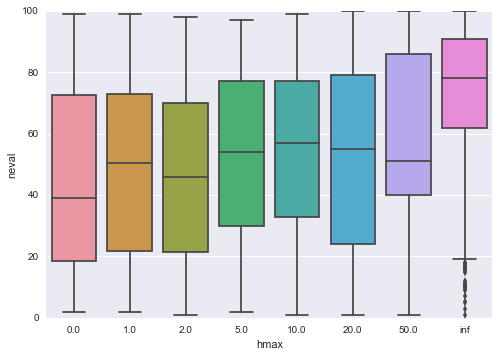

In [38]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability?

In [42]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [44]:
rel_by_hmax

,neval
hmax,
0.000000,0.0079
1.000000,0.0062
2.000000,0.0063
5.000000,0.0070
10.000000,0.0082
20.000000,0.0261
50.000000,0.0976
inf,0.3730


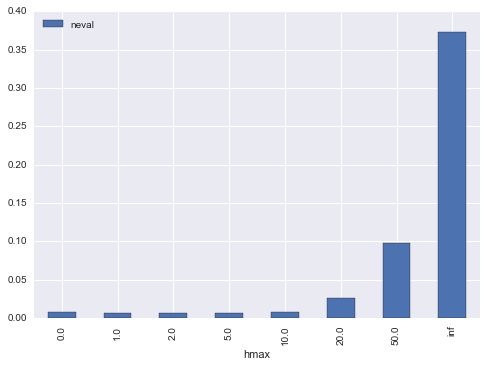

In [43]:
ax = rel_by_hmax.plot(kind='bar')

#### Feoktistov criterion?

In [40]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
)

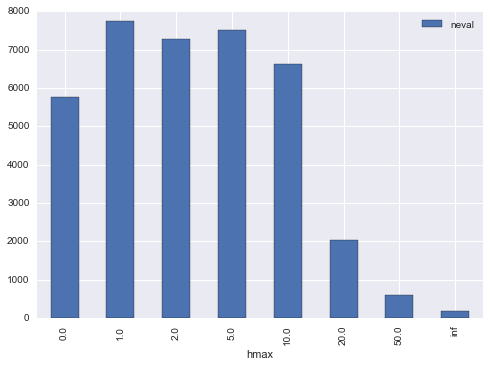

In [41]:
ax = feo_by_hmax.plot(kind='bar')

# Assignments

1. Implement examples in this notebook
1. Experiment with **neighbourhood diameter** `d` in `AirShip.get_neighborhood(x, d)`
1. Add **Random Descent** heuristic (similar to Shoot & Go, but does not follow steepest descent, chooses direction of the descent randomly instead) into existing framework and analyze its performance.
1. Add **Taboo Search** heuristic into existing framework and analyze its performance.